In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import kagglehub 
import json

In [2]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 64

# Number of channels in the training images. For color images this is 3
img_channels = 3

# Size of z latent vector (i.e. size of generator input)
latent_size = 100

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0001

# Beta hyperparameters for Adam optimizers
betas = (0.0, 0.9)

In [3]:
dataset_name = "soumikrakshit/anime-faces"
# dataset_name = "splcher/animefacedataset"
# dataset_name = "ziggykor/anime-face-dataset-expanded-2024"

formatted_dataset_name = dataset_name.replace("/","_")
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:" , path)

Path to dataset files: /Users/yusuf/.cache/kagglehub/datasets/soumikrakshit/anime-faces/versions/1


In [4]:
dataset = dset.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

print(f"Number of images in the dataset is {len(dataset)}")

Number of images in the dataset is 43102


In [5]:
dataset_without_transforms = dset.ImageFolder(root=path)

In [6]:
dataset[0][0].shape # each image has 3 channels and has a resolution of 64x64

torch.Size([3, 64, 64])

In [7]:
print(f"min value in dataset[0][0]: {dataset[0][0].min()}")
print(f"max value in dataset[0][0]: {dataset[0][0].max()}")

min value in dataset[0][0]: -1.0
max value in dataset[0][0]: 1.0


In [8]:
image_idx = np.random.randint(low=0, high=len(dataset), size=(4))
image_idx

array([17959,  8329,  1011, 18578])

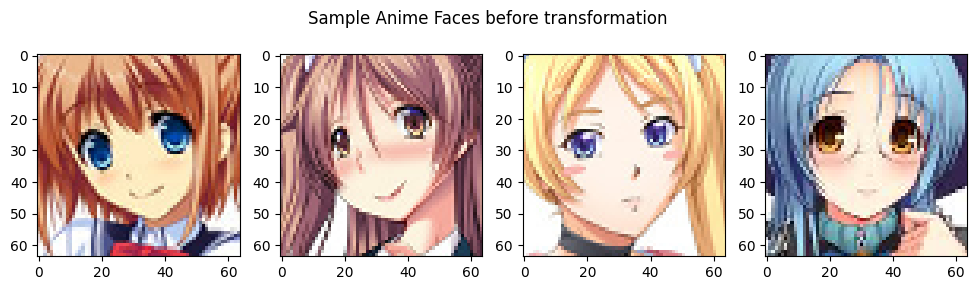

In [9]:
fix, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,3))
plt.suptitle("Sample Anime Faces before transformation") 

for i in range(4):
    idx = image_idx[i]
    ax[i].imshow(dataset_without_transforms[idx][0])

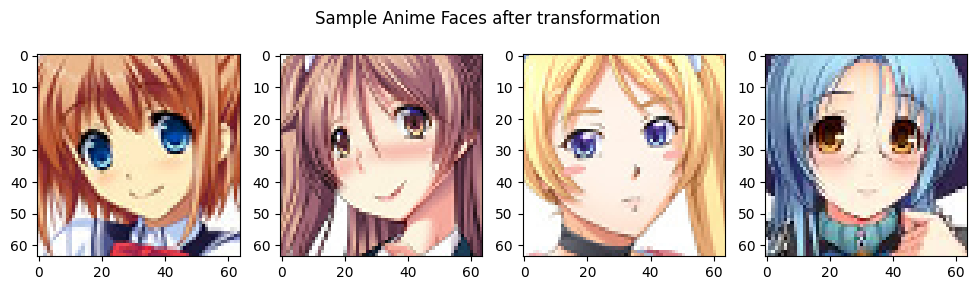

In [10]:
def denorm(img_tensors):
    return img_tensors * .5 + .5
    
fix, ax = plt.subplots(ncols=4, nrows=1, figsize=(12,3))
plt.suptitle("Sample Anime Faces after transformation")  # Adjust y-value

for i in range(4):
    idx = image_idx[i]
    ax[i].imshow(denorm(dataset[idx][0]).permute(1,2,0).detach().numpy())
plt.show()


In [11]:
# ## Select Device for Training
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

# Decide which device we want to run on
device = get_device()
print("Using device:", device)

Using device: mps


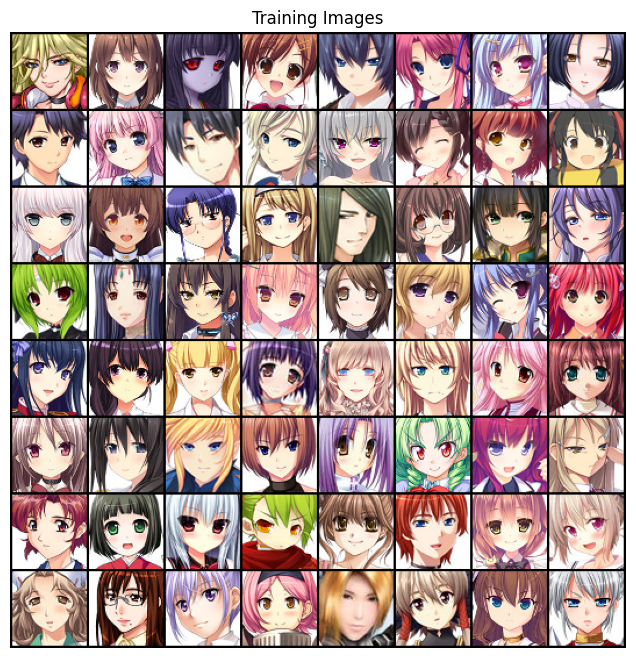

In [12]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [13]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # out: (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. ``(64*4) x 8 x 8``
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. ``(64*2) x 16 x 16``
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d( 64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [15]:
generator = Generator().to(device)

generator.apply(weights_init)

print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [16]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64 * 2),  # use InstanceNorm2d instead of BatchNorm2d
            nn.LeakyReLU(0.2, inplace=True),
            # out: (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # out: (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # out: (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            # out: 1 x 1 x 1

            # Note: No sigmoid in wgan-gp
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
critic = Critic().to(device)

critic.apply(weights_init)

print(critic)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [18]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device, lambda_gp=10):
    batch_size = real_samples.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolated.requires_grad_(True)
    
    # Get critic scores for interpolated samples
    interpolated_scores = critic(interpolated).view(-1)
    
    # Compute gradients of scores with respect to interpolated images
    gradients = torch.autograd.grad(
        outputs=interpolated_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_scores, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return penalty


In [19]:
# criterion = nn.BCELoss()

# fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# real_label = 1.
# fake_label = 0.

optimizerC = optim.Adam(critic.parameters(), lr=lr, betas=betas)
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=betas)

In [20]:
sample_dir = f"generated_images/{formatted_dataset_name}"
os.makedirs(sample_dir, exist_ok=True)

In [21]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

def save_samples(index, latent_tensors, generator, show=True):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    
    with torch.no_grad():
        fake = generator(latent_tensors).detach().cpu()
    
    # Convert tensor to image grid
    grid = vutils.make_grid(fake, padding=2, normalize=True).permute(1, 2, 0).numpy()
    
    # Plot and add a title
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.axis("off")  # Remove axis for a cleaner image
    plt.title(f"WGAN-GP, Epoch: {index}, Dataset: {dataset_name}")
    
    # Show the image if requested
    if show:
        plt.show()
    
    # Save the image with the title
    plt.savefig(os.path.join(sample_dir, fake_fname), bbox_inches="tight", pad_inches=0.2)
    plt.close()


In [22]:
latent_size=100
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [23]:
models_dir = f"models/{formatted_dataset_name}"
os.makedirs(models_dir, exist_ok=True)

In [24]:
def train_wgan_gp(num_epochs, dataloader, generator, critic, optimizerG, optimizerC, device, latent_size, fixed_latent, n_critic=5):
    G_losses = []
    C_losses = []
    
    print("Starting WGAN-GP Training Loop...")
    save_samples(0, fixed_latent, generator, show=False)

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            real_images = data[0].to(device)
            batch_size = real_images.size(0)
            
            # ---------------------
            #  Train Critic
            # ---------------------
            critic.zero_grad()
            
            # Generate fake images
            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(noise).detach()
            
            # Critic outputs
            critic_real = critic(real_images).view(-1)
            critic_fake = critic(fake_images).view(-1)
            
            # Compute gradient penalty
            gp = compute_gradient_penalty(critic, real_images, fake_images, device)
            
            # Critic loss: maximize D(real) - D(fake) => minimize loss = D(fake) - D(real) + gp
            loss_critic = critic_fake.mean() - critic_real.mean() + gp
            loss_critic.backward()
            optimizerC.step()
            
            C_losses.append(loss_critic.item())
            
            # Update generator every n_critic iterations
            if i % n_critic == 0:
                generator.zero_grad()
                noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = generator(noise)
                # Generator loss: minimize -D(fake) (i.e., maximize D(fake))
                loss_generator = -critic(fake_images).view(-1).mean()
                loss_generator.backward()
                optimizerG.step()
                G_losses.append(loss_generator.item())
            else:
                # Append None when generator is not updated
                G_losses.append(None)
            
            # (Optional) Print metrics every so often
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'Loss_Critic: {loss_critic.item():.4f}  Loss_Generator: {loss_generator.item():.4f}')
        
        save_samples(epoch+1, fixed_latent, generator, show=False)
        
        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'epoch': epoch + 1,
            }, f'{models_dir}/generator_checkpoint_epoch_{epoch+1}.pth')
            print(f'Model checkpoint saved at epoch {epoch+1}')
    
    return G_losses, C_losses


In [25]:
G_losses, C_losses = train_wgan_gp(
    num_epochs=num_epochs,
    dataloader=dataloader,
    generator=generator,
    critic=critic,
    optimizerG=optimizerG,
    optimizerC=optimizerC,
    device=device,
    latent_size=latent_size,
    fixed_latent=fixed_latent,
)

Starting WGAN-GP Training Loop...
Epoch [0/100] Batch [0/337] Loss_Critic: 468.3232  Loss_Generator: 0.1614
Epoch [0/100] Batch [100/337] Loss_Critic: -11.7609  Loss_Generator: 6.1337
Epoch [0/100] Batch [200/337] Loss_Critic: -16.1791  Loss_Generator: 1.4519
Epoch [0/100] Batch [300/337] Loss_Critic: -20.1007  Loss_Generator: 7.7038
Epoch [1/100] Batch [0/337] Loss_Critic: -15.6577  Loss_Generator: 3.4492
Epoch [1/100] Batch [100/337] Loss_Critic: -17.5172  Loss_Generator: 5.6836
Epoch [1/100] Batch [200/337] Loss_Critic: -19.3959  Loss_Generator: 15.3150
Epoch [1/100] Batch [300/337] Loss_Critic: -18.3660  Loss_Generator: 14.7108
Epoch [2/100] Batch [0/337] Loss_Critic: -15.9050  Loss_Generator: 9.4833
Epoch [2/100] Batch [100/337] Loss_Critic: -16.9989  Loss_Generator: 10.6756
Epoch [2/100] Batch [200/337] Loss_Critic: -18.3207  Loss_Generator: 12.5679
Epoch [2/100] Batch [300/337] Loss_Critic: -19.6868  Loss_Generator: 18.0834
Epoch [3/100] Batch [0/337] Loss_Critic: -17.6076  Loss

In [26]:
torch.save({
    'generator_state_dict': generator.state_dict(),
    'critic_state_dict': critic.state_dict(),
    'optimizerG_state_dict': optimizerG.state_dict(),
    'optimizerC_state_dict': optimizerC.state_dict(),
    'epoch': num_epochs,
}, f'models/{formatted_dataset_name}/model_checkpoint_latest.pth')
print(f'Latest model checkpoint saved')

# Save final loss data
loss_data = {
    "G_losses": G_losses,
    "C_losses": C_losses
}

with open(f"models/{formatted_dataset_name}/losses_final.json", "w") as f:
    json.dump(loss_data, f)

print("Final loss data saved in models/losses_final.json")

Latest model checkpoint saved
Final loss data saved in models/losses_final.json


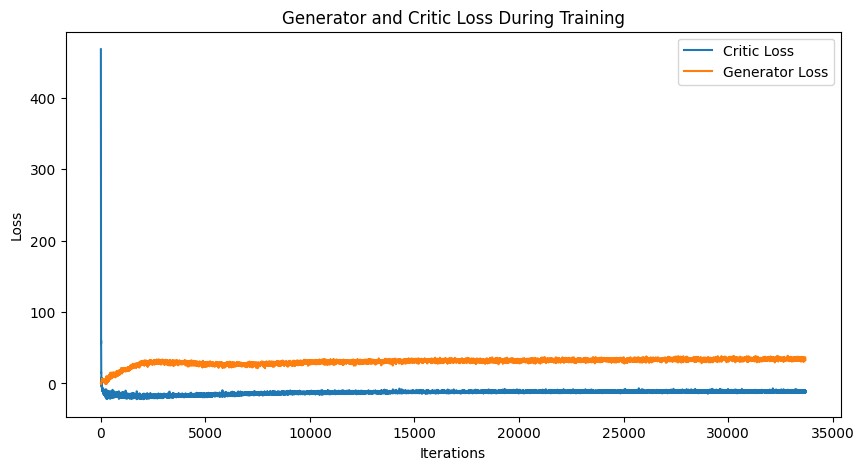

In [33]:
# Create an array for critic iterations (recorded every iteration)
iterations_critic = np.arange(len(C_losses))

# Extract the indices and corresponding losses for generator updates (non-None values)
gen_indices = [i for i, loss in enumerate(G_losses) if loss is not None]
gen_losses = [loss for loss in G_losses if loss is not None]

plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(iterations_critic, C_losses, label="Critic Loss")
plt.plot(gen_indices, gen_losses, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
